In [1]:
print("""Feedback from Brian:
1) Heatmap Plot
2) Combine to put all ephys features in one plot

*Use Tree call column when you have a large dataset
*Use NMS for smaller dataset now""")

Feedback from Brian:
1) Heatmap Plot
2) Combine to put all ephys features in one plot

*Use Tree call column when you have a large dataset
*Use NMS for smaller dataset now


##### Imports 

In [2]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "white", font="verdana") # font_scale = 1.35)

##### Logging Set-up

In [3]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

##### Pandas Display Settings

In [4]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Lists/Paths

In [5]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [6]:
path_jem = os.path.join(csv_path, "jem_metadata_wFAILURE.csv")
path_ephys = os.path.join(csv_path, "ephys_mIVSCC_MET.csv")
path_shiny = os.path.join(csv_path, "Mouse_VISp_ctx_shiny.csv")

In [7]:
fields_jem = ["date", "organism_name", "container", "rigOperator", "status", "roi"]
              #"extraction.postPatch", "extraction.endPipetteR"]
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
fields_shiny = ["patch.date", "cell_name", "sample_id", "cell_specimen_project",
                "subclass_label", "broad_class_label",
                "marker_sum_norm_label", "Norm_Marker_Sum.0.4_label"] #"Tree_call", "topLeaf_label"

In [8]:
drop_nans_list = ["date"]
drop_cols_list = ["sample_id", "patch.date", "status", "name", "cell_specimen_project", "organism_name"]

##### Writing to Excel File

In [9]:
def save_to_excel():
    """"""
    writer = pd.ExcelWriter(excel_path + "mephys_final_home.xlsx")
    rsp_visp_glu.to_excel(writer, "RSP_VISP_Glu", freeze_panes=(1,0))
    rsp_glu.to_excel(writer, "RSP_Glu", freeze_panes=(1,0))
    visp_glu.to_excel(writer, "VISP_Glu", freeze_panes=(1,0))
    merge_all.to_excel(writer, "All", freeze_panes=(1,0))
    merge_sj.to_excel(writer, "Shiny_Jem", freeze_panes=(1,0))
    shiny.to_excel(writer, "Shiny", freeze_panes=(1,0))
    jem.to_excel(writer, "Jem", freeze_panes=(1,0))
    ephys.to_excel(writer, "Ephys", freeze_panes=(1,0))
    writer.save()
    LOGGER.info("All dataframes have been saved to excel file")

##### Main

In [10]:
def main():
    global jem, shiny, ephys, merge_sj, merge_all, merge_all_glu, merge_all_gab, rsp_glu, visp_glu, rsp_visp_glu
    jem = read_file(path_jem, fields_jem) #20843 rows
    ephys = read_file(path_ephys, fields_ephys) #8541 rows
    shiny = read_file(path_shiny, fields_shiny) #10674 rows

    jem = filter_df(jem, "status", "SUCCESS") #13325 rows
    jem = filter_date_range(jem, "date") #6335 rows
    
    shiny = filter_df(shiny, "Norm_Marker_Sum.0.4_label", True) #9101 rows
    shiny = filter_date_range(shiny, "patch.date") #2849 rows

    merge_sj = merge_dataframes(shiny, jem, "sample_id", "container", "inner") #2850 rows (even if how=left)
    merge_all = merge_dataframes(merge_sj, ephys, "cell_name", "name", "inner") #2635 rows

    merge_all = drop_nans(merge_all, drop_nans_list)
    merge_all = drop_cols(merge_all, drop_cols_list)
    merge_all = create_container_col(merge_all, "rigOperator")
    merge_all.set_index("date", inplace=True)
    
    merge_all["region"] = pd.np.where(merge_all.roi.str.contains("RSP"), "RSP", 
                                      pd.np.where(merge_all.roi.str.contains("VISp"), "VISp", 
                                      pd.np.where(merge_all.roi.str.contains("TEa"), "TEa",
                                      pd.np.where(merge_all.roi.str.contains("CTXsp"), "CLA",
                                      pd.np.where(merge_all.roi.str.contains("MO"), "MO",
                                      pd.np.where(merge_all.roi.str.contains("ORB"), "ORB",
                                      pd.np.where(merge_all.roi.str.contains("SSp"), "SSp",
                                      pd.np.where(merge_all.roi.str.contains("HY"), "HY", "Unknown"))))))))
    
    merge_all_glu = create_cond_df(merge_all, "broad_class_label", ["Glutamatergic"])
    merge_all_gab = create_cond_df(merge_all, "broad_class_label", ["GABAergic"])

    rsp_glu = create_cond_df(merge_all_glu, "region", ["RSP"])
    visp_glu = create_cond_df(merge_all_glu, "region", ["VISp"])
    rsp_visp_glu = pd.concat([rsp_glu, visp_glu])
    

In [11]:
if __name__ == "__main__":
    main()
    entry = input("Type y or n to save dataframes to excel file:")
    if entry.lower() == "y":
        save_to_excel()
    elif entry.lower() == "n":
        LOGGER.info("The dataframes did not get saved to excel file.")
    else:
        LOGGER.info("Please print y or n.")

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Filtered dataframe based on status == SUCCESS
C:\Users\kumar\Documents\GitHub\analysis_projects\analysis_scripts\functions\temp_funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values([date_col], inplace=True)
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Filtered dataframe based on Norm_Marker_Sum.0.4_label == True
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp

Type y or n to save dataframes to excel file:y


INFO:__main__:All dataframes have been saved to excel file


##### Count Tracker for subclasses

In [12]:
merge_all.reset_index(inplace=True)

In [13]:
start_date = merge_all["date"].str[0:10].min()
end_date = merge_all["date"].str[0:10].max()
print(f"Start date: {start_date} & End Date: {end_date}")

Start date: 2019-01-03 & End Date: 2020-02-03


In [14]:
merge_all.subclass_label.unique()

array(['Vip', 'Sst', 'L6 Car3', 'Pvalb', 'Sst Chodl', 'Sncg', 'L6 CT CTX',
       'Lamp5', 'L5 ET CTX', 'L5 IT CTX', 'L4/5 IT CTX', 'L6 IT CTX',
       'L2/3 IT CTX', 'L5 NP CTX', 'L6b CTX', 'L2 IT RSP-ACA', 'DG',
       'L6 CT SUB', 'L5 IT TPE-ENT', 'L2/3 IT PPP', 'L2 IT ENTm',
       'L5 PPP', 'L3 RSP-ACA', 'SUB', 'L2/3 IT TPE', 'L6 CT L6b ENT',
       'L2/3 IT ENTl'], dtype=object)

In [15]:
#fig_dims = (20, 10)
#f, axes = plt.subplots(figsize=fig_dims)

#sns.countplot(x="subclass_label", data=merge_all)

##### Misc Info

In [16]:
#merge_all #2787 rows
#merge_all_glu #1583 rows
#merge_all_gab #1204 rows

In [17]:
rsp_visp_glu.reset_index(inplace=True)
rsp_visp_glu.sort_values(["subclass_label"], inplace=True)
rsp_glu.sort_values(["subclass_label"], inplace=True)
visp_glu.sort_values(["subclass_label"], inplace=True)

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [18]:
#rsp_visp_glu #1424 rows
#Start Date: 1.04.2019 
#End Date: 1.31.2020
#rsp_visp_glu

In [19]:
#rsp_glu.replace({"roi_major": {"RSPd": "RSP", "RSPv": "RSP"}}, inplace=True)
#mo_glu.replace({"roi_major": {"MOp": "MO", "MOs": "MO"}}, inplace=True)

In [20]:
"""
region_dict = {"Overall Mouse Total count": merge_all.name.count(),
               "RSP Total": rsp.name.count(),
               "SSp Total": ssp.name.count(),
               "ORB Total": orb.name.count(),
               "CTXsp Total": ctxsp.name.count(),
               "MO Total": mo.name.count(),
               "VISp Total": visp.name.count()}

glu_dict = {"Glutamatergic Mouse Total count": merge_all_glu.name.count(),
            "RSP": rsp_glu.name.count(),
            "SSp": ssp_glu.name.count(),
            "ORB": orb_glu.name.count(),
            "CTXsp": ctxsp_glu.name.count(),
            "MO": mo_glu.name.count(),
            "VISp": visp_glu.name.count()}

gab_dict = {"GABAergic Mouse Total count": merge_all_gab.name.count(),
            "RSP": rsp_gab.name.count(),
            "SSp": ssp_gab.name.count(),
            "ORB": orb_gab.name.count(),
            "CTXsp": ctxsp_gab.name.count(),
            "MO": mo_gab.name.count(),
            "VISp": visp_gab.name.count()}

for k,v in region_dict.items():
    print(f"{k} : {v}")
    
for k,v in glu_dict.items():
    print(f"{k} : {v}")

for k,v in gab_dict.items():
    print(f"{k} : {v}")
"""

'\nregion_dict = {"Overall Mouse Total count": merge_all.name.count(),\n               "RSP Total": rsp.name.count(),\n               "SSp Total": ssp.name.count(),\n               "ORB Total": orb.name.count(),\n               "CTXsp Total": ctxsp.name.count(),\n               "MO Total": mo.name.count(),\n               "VISp Total": visp.name.count()}\n\nglu_dict = {"Glutamatergic Mouse Total count": merge_all_glu.name.count(),\n            "RSP": rsp_glu.name.count(),\n            "SSp": ssp_glu.name.count(),\n            "ORB": orb_glu.name.count(),\n            "CTXsp": ctxsp_glu.name.count(),\n            "MO": mo_glu.name.count(),\n            "VISp": visp_glu.name.count()}\n\ngab_dict = {"GABAergic Mouse Total count": merge_all_gab.name.count(),\n            "RSP": rsp_gab.name.count(),\n            "SSp": ssp_gab.name.count(),\n            "ORB": orb_gab.name.count(),\n            "CTXsp": ctxsp_gab.name.count(),\n            "MO": mo_gab.name.count(),\n            "VISp": vi

##### Plot Functions

In [21]:
b_colors={"RSP": "#a1d99b", "VISp": "#9ecae1"}
s_colors={"RSP": "#41ab5d", "VISp": "#4292c6"}

In [22]:
region_list = ["RSP", "VISp"]
sub_list = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"]

In [23]:
rsub_list = list()
rless_list = list()
for n in rsp_glu.subclass_label.unique():
    ex = rsp_glu[rsp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        rsub_list.append(n)
    else:
        rless_list.append(n)

vsub_list = list()
vless_list = list()
for n in visp_glu.subclass_label.unique():
    ex = visp_glu[visp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        vsub_list.append(n)
    else:
        vless_list.append(n)
        
#print(f"This list has greater than 5 datapoints: {rsub_list}")
#print(f"This list has less than 5 datapoints: {rless_list}")
#print(f"This list has greater than 5 datapoints: {vsub_list}")
#print(f"This list has less than 5 datapoints: {vless_list}")

sub_list = list(set(rsub_list) & set(vsub_list))
print(f"Combined subclass list(greater than 5 datapoints): {sub_list}")

Combined subclass list(greater than 5 datapoints): ['L2 IT RSP-ACA', 'L5 ET CTX', 'L5 NP CTX']


##### Function for Box Plot

In [24]:
def box_plt(col_y, jpg_title, plt_title, ylim_min, ylim_max, df=rsp_visp_glu):
    """Creates a box plot using seaborn and compares the ephys features between
    two mouse regions while displaying the t-types.
    Args:
        col_y(string): y-axis column
        jpg_title(string): title of the jpeg file
        plt_tile(string): title of the plot
        df: a pandas dataframe
    Returns: None
    """
    fig_dims = (4, 8)
    f, axes = plt.subplots(figsize=fig_dims)

    ax = sns.boxplot(x="subclass_label", y=col_y, hue="region", data=df[df[col_y] < ylim_max],
                     order = sub_list, hue_order = region_list,
                     palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False)

    ax = sns.stripplot(x="subclass_label", y=col_y, hue="region", data=df[df[col_y] < ylim_max],
                       order = sub_list, hue_order = region_list,
                       jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5)
    
    #sns.despine(trim=True)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], title="Region")
    
    #ax.legend_.remove()
    ax.set(xlabel="Subclass", ylabel=plt_title)
    ax.set(ylim=(ylim_min, ylim_max))
    plt.savefig(plot_path + "box_plt_" + jpg_title + ".jpeg", bbox_inches="tight")

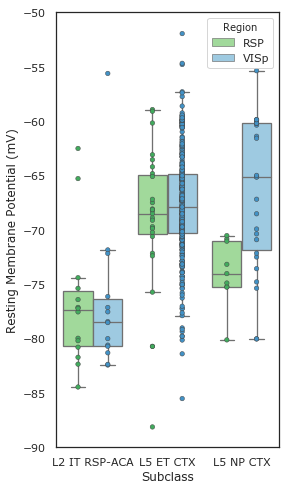

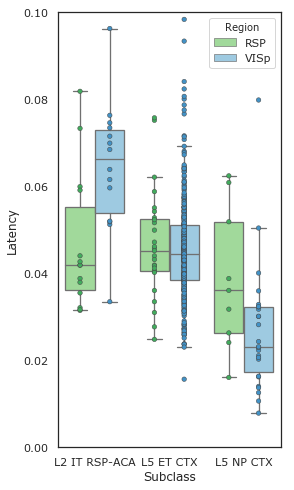

In [25]:
box_plt("vrest", "rmp", "Resting Membrane Potential (mV)", -90, -50)
#box_plt("sag", "sag", "Sag", 0, 0.35)
#box_plt("tau", "tau", "Time Constant", 0, 35)
#box_plt("upstroke_downstroke_ratio_long_square", "udr", "Upstroke/Downstroke", 0, 6)
box_plt("latency", "lat", "Latency", 0, 0.10)
#box_plt("f_i_curve_slope", "fis", "F-I Curve", 0, 0.60)

##### Creating multiple subplots for boxplots

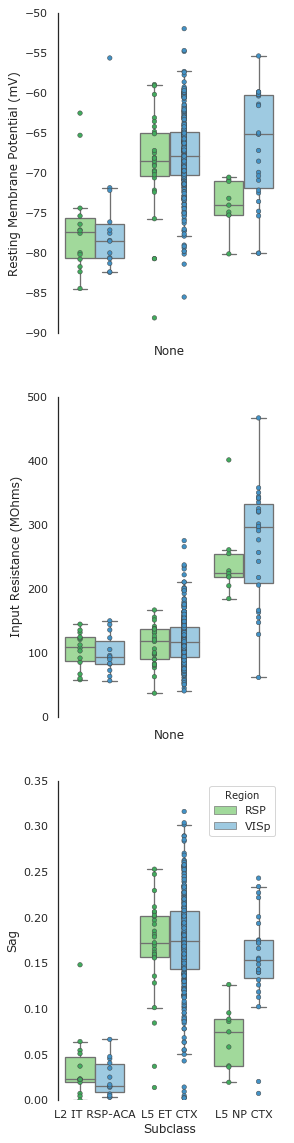

In [26]:
fig_dims = (4, 20)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)


ax = sns.boxplot(x="subclass_label", y="vrest", hue="region", data=rsp_visp_glu[rsp_visp_glu["vrest"] < -50],
                 order = sub_list, hue_order = region_list,
                 palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[0])


ax = sns.stripplot(x="subclass_label", y="vrest", hue="region", data=rsp_visp_glu[rsp_visp_glu["vrest"] < -50],
                   order = sub_list, hue_order = region_list,
                   jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[0])


ax1 = sns.boxplot(x="subclass_label", y="ri", hue="region", data=rsp_visp_glu[rsp_visp_glu["ri"] < 500],
                  order = sub_list, hue_order = region_list,
                  palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[1])

ax1 = sns.stripplot(x="subclass_label", y="ri", hue="region", data=rsp_visp_glu[rsp_visp_glu["ri"] < 500],
                    order = sub_list, hue_order = region_list,
                    jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[1])


ax2 = sns.boxplot(x="subclass_label", y="sag", hue="region", data=rsp_visp_glu[rsp_visp_glu["sag"] < 0.35],
                  order = sub_list, hue_order = region_list,
                  palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[2])

ax2 = sns.stripplot(x="subclass_label", y="sag", hue="region", data=rsp_visp_glu[rsp_visp_glu["sag"] < 0.35],
                    order = sub_list, hue_order = region_list,
                    jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[2])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], title="Region")

ax.legend_.remove()
ax1.legend_.remove()
#ax2.legend_.remove()

ax.set(ylim=(-90, -50))
ax1.set(ylim=(0, 500))
ax2.set(ylim=(0, 0.35))
ax.set(xlabel=None, ylabel="Resting Membrane Potential (mV)")
ax1.set(xlabel=None, ylabel="Input Resistance (MOhms)")
ax2.set(xlabel="Subclass", ylabel="Sag")

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
sns.despine(bottom=True)

##### HeatMap

In [27]:
rsp_glu.reset_index(inplace=True)
visp_glu.reset_index(inplace=True)

In [28]:
r_df = rsp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]]
r_df = r_df.groupby(["subclass_label", "region"]).mean().reset_index()

In [29]:
v_df = visp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]]
v_df = v_df.groupby(["subclass_label", "region"],).mean().reset_index()

In [30]:
heatmap_df = pd.merge(left=r_df, right=v_df, on="subclass_label")

In [31]:
heatmap_df["vrest"] = ((heatmap_df["vrest_x"] - heatmap_df["vrest_y"]) / heatmap_df["vrest_y"]) * 100 #new - old/old  = r - v/v
heatmap_df["ri"] = ((heatmap_df["ri_x"] - heatmap_df["ri_y"]) / heatmap_df["ri_y"]) * 100
heatmap_df["sag"] = ((heatmap_df["sag_x"] - heatmap_df["sag_y"]) / heatmap_df["sag_y"]) * 100
heatmap_df["tau"] = ((heatmap_df["tau_x"] - heatmap_df["tau_y"]) / heatmap_df["tau_y"]) * 100
heatmap_df["upstroke_downstroke_ratio_long_square"] = abs((heatmap_df["upstroke_downstroke_ratio_long_square_x"] - heatmap_df["upstroke_downstroke_ratio_long_square_y"]) / heatmap_df["upstroke_downstroke_ratio_long_square_y"]) * 100
heatmap_df["latency"] = ((heatmap_df["latency_x"] - heatmap_df["latency_y"]) / heatmap_df["latency_y"]) * 100
heatmap_df["f_i_curve_slope"] = ((heatmap_df["f_i_curve_slope_x"] - heatmap_df["f_i_curve_slope_y"]) / heatmap_df["f_i_curve_slope_y"]) * 100

In [32]:
heatmap_df

,subclass_label,region_x,vrest_x,ri_x,sag_x,tau_x,upstroke_downstroke_ratio_long_square_x,latency_x,f_i_curve_slope_x,region_y,vrest_y,ri_y,sag_y,tau_y,upstroke_downstroke_ratio_long_square_y,latency_y,f_i_curve_slope_y,vrest,ri,sag,tau,upstroke_downstroke_ratio_long_square,latency,f_i_curve_slope
0,L2 IT RSP-ACA,RSP,-76.811338,104.348811,0.035903,10.586263,2.925136,0.046587,0.198403,VISp,-76.773133,98.861731,0.024403,12.694613,4.122600,0.064600,0.161421,0.049764,5.550257,47.123079,-16.608223,29.046333,-27.883680,22.910700
1,L2/3 IT CTX,RSP,-79.119185,57.729140,0.014439,9.543382,4.441768,0.073660,0.120000,VISp,-77.377667,67.836134,0.023004,11.676442,4.314961,0.080301,0.134687,2.250672,-14.899130,-37.229532,-18.268066,2.938771,-8.269713,-10.904747
2,L3 RSP-ACA,RSP,-65.180289,86.825591,0.289668,13.088296,3.033503,0.041252,0.193444,VISp,-66.775607,75.374946,0.231917,8.989039,2.707995,0.029440,0.300000,-2.389072,15.191579,24.901747,45.602839,12.020258,40.123981,-35.518800
3,L4/5 IT CTX,RSP,-59.979497,177.957054,0.101669,43.732152,3.563717,0.039470,0.690908,VISp,-70.795548,162.471682,0.064352,19.944293,3.988628,0.062423,0.187472,-15.277870,9.531121,57.988783,119.271509,10.653053,-36.770303,268.539526
4,L5 ET CTX,RSP,-69.061524,111.394068,0.166532,15.468225,3.597249,0.046611,0.155662,VISp,-67.587740,118.302890,0.172716,17.279266,3.599296,0.048491,0.163207,2.180550,-5.839944,-3.580804,-10.481009,0.056873,-3.877011,-4.622775
5,L5 IT CTX,RSP,-67.201502,217.835734,0.063916,28.400857,3.220501,0.040333,0.182440,VISp,-71.368605,209.809391,0.095233,24.488164,3.441350,0.046932,0.147395,-5.838847,3.825540,-32.884357,15.977892,6.417504,-14.059553,23.776122
6,L5 NP CTX,RSP,-73.900963,243.984663,0.069398,18.792059,3.797228,0.038696,0.353778,VISp,-66.517502,270.316173,0.153057,22.180426,4.213208,0.026652,0.273864,11.100027,-9.741004,-54.659084,-15.276384,9.873225,45.190701,29.180182
7,L6 CT CTX,RSP,-72.319739,102.999970,0.098378,9.024144,2.354674,0.031620,0.084603,VISp,-70.724212,173.522547,0.129680,15.924181,3.101322,0.036160,0.178346,2.255984,-40.641737,-24.137485,-43.330561,24.075162,-12.554953,-52.562494
8,L6 IT CTX,RSP,-66.040516,135.484431,0.038903,16.311519,4.129084,0.062960,0.167946,VISp,-73.203375,147.771758,0.051016,17.049474,4.229675,0.050674,0.188047,-9.784875,-8.315071,-23.743077,-4.328312,2.378232,24.245528,-10.688966
9,L6b CTX,RSP,-61.183310,349.539767,0.189573,32.159326,3.942913,0.189047,0.107263,VISp,-68.607158,207.526891,0.056418,19.564715,4.583395,0.045027,0.236287,-10.820807,68.431072,236.015394,64.374108,13.973955,319.853728,-54.604933


In [33]:
heatmap_df.drop(columns=["vrest_x", "vrest_y",
                    "ri_x", "ri_y", 
                    "sag_x", "sag_y", 
                    "tau_x", "tau_y",
                    "upstroke_downstroke_ratio_long_square_x", "upstroke_downstroke_ratio_long_square_y",
                    "latency_x", "latency_y",
                    "f_i_curve_slope_x", "f_i_curve_slope_y",
                    "region_x", "region_y"], inplace=True)

heatmap_df.rename(columns={"vrest": "Vm(mV)", 
                      "ri": "Input Resistance(MΩ)",
                      "sag" : "Sag Fraction",
                      "tau": "τ(s)",
                      "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke",
                      "latency" : "Latency",
                      "f_i_curve_slope" : "F-I Curve"}, inplace=True)

heatmap_df = heatmap_df.melt(id_vars=["subclass_label"],
                             value_vars=["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)",
                                         "LS AP up/downstoke", "Latency", "F-I Curve"],
                             var_name="ephys_features", value_name="%change from VISp")

In [34]:
heatmap_df = pd.pivot_table(heatmap_df, values='%change from VISp', index=["ephys_features"], columns="subclass_label")

In [35]:
heatmap_df

subclass_label,L2 IT RSP-ACA,L2/3 IT CTX,L3 RSP-ACA,L4/5 IT CTX,L5 ET CTX,L5 IT CTX,L5 NP CTX,L6 CT CTX,L6 IT CTX,L6b CTX
ephys_features,,,,,,,,,,
F-I Curve,22.910700,-10.904747,-35.518800,268.539526,-4.622775,23.776122,29.180182,-52.562494,-10.688966,-54.604933
Input Resistance(MΩ),5.550257,-14.899130,15.191579,9.531121,-5.839944,3.825540,-9.741004,-40.641737,-8.315071,68.431072
LS AP up/downstoke,29.046333,2.938771,12.020258,10.653053,0.056873,6.417504,9.873225,24.075162,2.378232,13.973955
Latency,-27.883680,-8.269713,40.123981,-36.770303,-3.877011,-14.059553,45.190701,-12.554953,24.245528,319.853728
Sag Fraction,47.123079,-37.229532,24.901747,57.988783,-3.580804,-32.884357,-54.659084,-24.137485,-23.743077,236.015394
Vm(mV),0.049764,2.250672,-2.389072,-15.277870,2.180550,-5.838847,11.100027,2.255984,-9.784875,-10.820807
τ(s),-16.608223,-18.268066,45.602839,119.271509,-10.481009,15.977892,-15.276384,-43.330561,-4.328312,64.374108


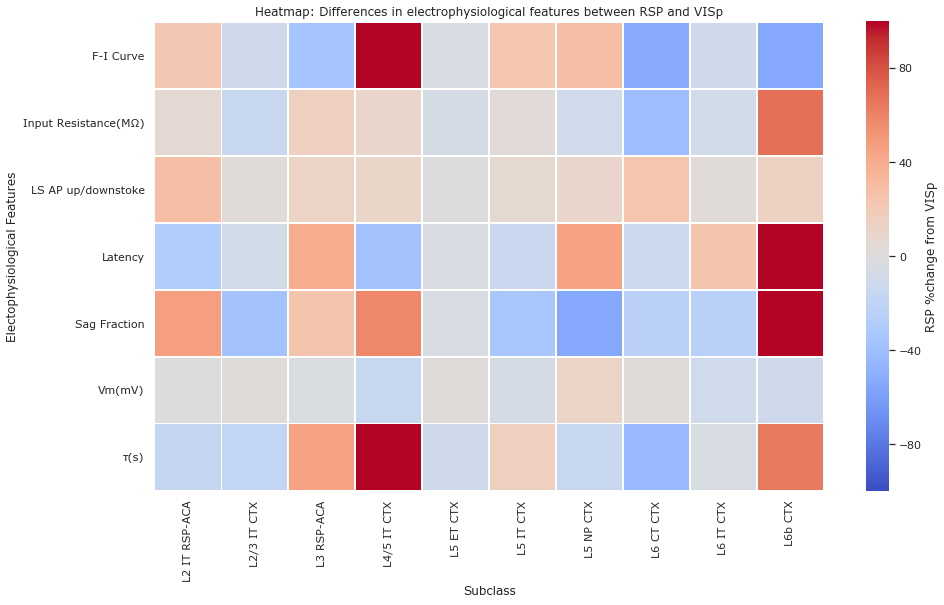

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data=heatmap_df,
            vmin=-100, 
            vmax=100,
            cmap="coolwarm",
            center=0,
            #robust=True,
            #annot=True
            linewidths=0.5,
            square=True,
            cbar=True,
            cbar_kws={"label": "RSP %change from VISp", "shrink": 0.865})
plt.ylabel("Electophysiological Features")
plt.xlabel("Subclass")
plt.title("Heatmap: Differences in electrophysiological features between RSP and VISp")
plt.savefig(plot_path + "heatmap.jpeg", bbox_inches="tight")

In [37]:
"""Or, since you're mostly interested in whether there's a change you might imagine turning it into a heatmap,
where columns are t-types, rows are features and color indicates % change from VISp, for example.
"""
heatmap1_data = pd.pivot_table(heatmap_df, values='%change from VISp', 
                     index=["ephys_features"], 
                     columns="subclass_label")
#sns.heatmap(data=rsp_glu, vmin=0, vmax=1, linewidths=.5)

KeyError: '%change from VISp'